In [1]:
%matplotlib inline
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

from aux import find_segs, load_data
from disp import set_font_size
from lin_fit import make_extended_predictor_matrix


# DATA
EXPT = 'ASENSORY_AZ'
BASE = 'BigMAT.csv'

COLS = [
    ('Time', 'Time'),
    ('G2', 'G2_avg'),
    ('G3', 'G3_avg'),
    ('G4', 'G4_avg'),
    ('G5', 'G5_avg'),
    ('Motion', 'Motion'),
    ('ForVel', 'ForVel'),
    ('AngVel', 'AngVel'),
    ('AbsAngVel', 'AngVel', np.abs),
]

NORMED_COLS = ['G2', 'G3', 'G4', 'G5', 'Motion', 'ForVel', 'AngVel', 'AbsAngVel']

ODOR = None

COLORS = {
    'G2': 'r', 'G3': 'c', 'G4': 'g', 'G5': 'm',
    'Motion': 'k', 'ForVel': 'k', 'AngVel': 'k',
}

# ANALYSIS
SMOOTH_MOTION = (-0.25, 0.25)
W_CUTOFF_BALL = 0.02

T_PAD_W = 0.5
T_PAD_P = 0.5

DT = 0.1

CHUNK_DUR = 2
FRAC = 0.8
N_SPLITS = 100

WDW_FILT = (-0.5, 0.6)

PRED_SETS = [
    ('G2',),
    ('G3',),
    ('G4',),
    ('G5',),
    ('G2', 'G3', 'G4', 'G5'),
]

PLOT_XMPS = [('G2',), ('G3',), ('G2', 'G3', 'G4', 'G5')]

BINS = np.linspace(0, 1, 20 + 1)
BINS_FRAC_W = np.linspace(0, 1, 20 + 1)

FRAC_W_CUTOFF = 0.8

SEED = 0

# Load data

In [3]:
d = load_data(EXPT, BASE, COLS, NORMED_COLS, ODOR)

# DAN and BEHAV example traces

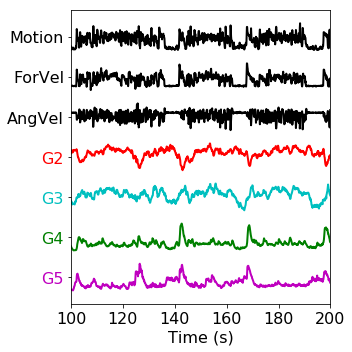

In [7]:
fig_size = (5, 5)
font_size = 16
trial = d.trials[0]
t_wdw = (100, 200)
vs = ['Motion', 'ForVel', 'AngVel', 'G2', 'G3', 'G4', 'G5']

t = d.d_n[trial]['Time']
t_mask = (t_wdw[0] <= t) & (t < t_wdw[1])

fig, ax = plt.subplots(1, 1, figsize=fig_size, tight_layout=True)

offsets = []

for v_ctr, v in enumerate(vs):
    x = d.d_n[trial][v][t_mask]
    x -= x.min()
    x /= x.max()
    
    offset = -((v_ctr+1)*1.5)
    ax.plot(t[t_mask], x + offset, lw=2, c=COLORS[v])
    
    offsets.append(offset)
    
offsets = np.array(offsets)

ax.set_xlim(t_wdw)
ax.set_ylim(-(len(vs) * 1.5) - 0.5, 0)

ax.set_yticks(offsets + 0.5)
ax.set_yticklabels(vs)

for y_tick, v in zip(ax.get_yticklabels(), vs):
    y_tick.set_color(COLORS[v])

ax.set_xlabel('Time (s)')

set_font_size(ax, font_size)

# DAN/ball-motion overlay

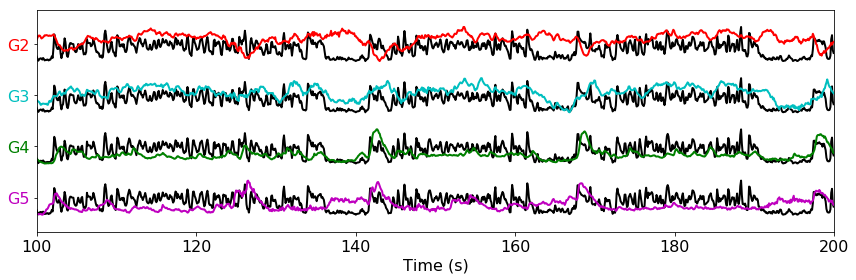

In [6]:
fig_size = (12, 4)
font_size = 16
t_wdw = (100, 200)

fig, ax = plt.subplots(1, 1, figsize=fig_size, tight_layout=True)

t = d.d_n[trial]['Time']
t_mask = (t_wdw[0] <= t) & (t < t_wdw[1])

motion = d.d_n[trial]['Motion'][t_mask]
motion -= motion.min()
motion /= motion.max()

vs = ['G2', 'G3', 'G4', 'G5']

offsets = []

for v_ctr, v in enumerate(vs):
    x = d.d_n[trial][v][t_mask]
    x -= x.min()
    x /= x.max()
    
    offset = (-(v_ctr+1) * 1.5)
    
    ax.plot(t[t_mask], motion + offset, lw=2, c=COLORS['Motion'])
    ax.plot(t[t_mask], x + offset, lw=2, c=COLORS[v])
    
    offsets.append(offset)
    
offsets = np.array(offsets)

ax.set_xlim(t_wdw)
ax.set_ylim(-(len(vs) * 1.5) - 0.5, 0)

ax.set_yticks(offsets + 0.5)
ax.set_yticklabels(vs)

for y_tick, v in zip(ax.get_yticklabels(), vs):
    y_tick.set_color(COLORS[v])

ax.set_xlabel('Time (s)')

set_font_size(ax, font_size)

# Fit classifier

In [5]:
def smooth_ma(t, x, wdw):
    """Smoothe a time-series using a moving average."""
    x_ma = np.nan * np.zeros(x.shape)
    
    for t_ctr, t_ in enumerate(t):
        mask = ((t_ + wdw[0]) <= t) & (t < (t_ + wdw[1]))

        if np.sum(~np.isnan(x[mask])):
            x_ma[t_ctr] = np.nanmean(x[mask])
            
    return x_ma

In [6]:
# create a smoothed version of the net ball rotation, using a moving average
for tr_ctr, trial in enumerate(d.trials):
    sys.stdout.write('{}/{} '.format(tr_ctr+1, len(d.trials)))
    t = d.d_u[trial]['Time']
    motion = d.d_u[trial]['Motion']
    d.d_u[trial]['MotionSmooth'] = smooth_ma(t, motion, SMOOTH_MOTION)

1/178 2/178 3/178 4/178 5/178 6/178 7/178 8/178 9/178 10/178 11/178 12/178 13/178 14/178 15/178 16/178 17/178 18/178 19/178 20/178 21/178 22/178 23/178 24/178 25/178 26/178 27/178 28/178 29/178 30/178 31/178 32/178 33/178 34/178 35/178 36/178 37/178 38/178 39/178 40/178 41/178 42/178 43/178 44/178 45/178 46/178 47/178 48/178 49/178 50/178 51/178 52/178 53/178 54/178 55/178 56/178 57/178 58/178 59/178 60/178 61/178 62/178 63/178 64/178 65/178 66/178 67/178 68/178 69/178 70/178 71/178 72/178 73/178 74/178 75/178 76/178 77/178 78/178 79/178 80/178 81/178 82/178 83/178 84/178 85/178 86/178 87/178 88/178 89/178 90/178 91/178 92/178 93/178 94/178 95/178 96/178 97/178 98/178 99/178 100/178 101/178 102/178 103/178 104/178 105/178 106/178 107/178 108/178 109/178 110/178 111/178 112/178 113/178 114/178 115/178 116/178 117/178 118/178 119/178 120/178 121/178 122/178 123/178 124/178 125/178 126/178 127/178 128/178 129/178 130/178 131/178 132/178 133/178 134/178 135/178 136/178 137/178 138/178 139/

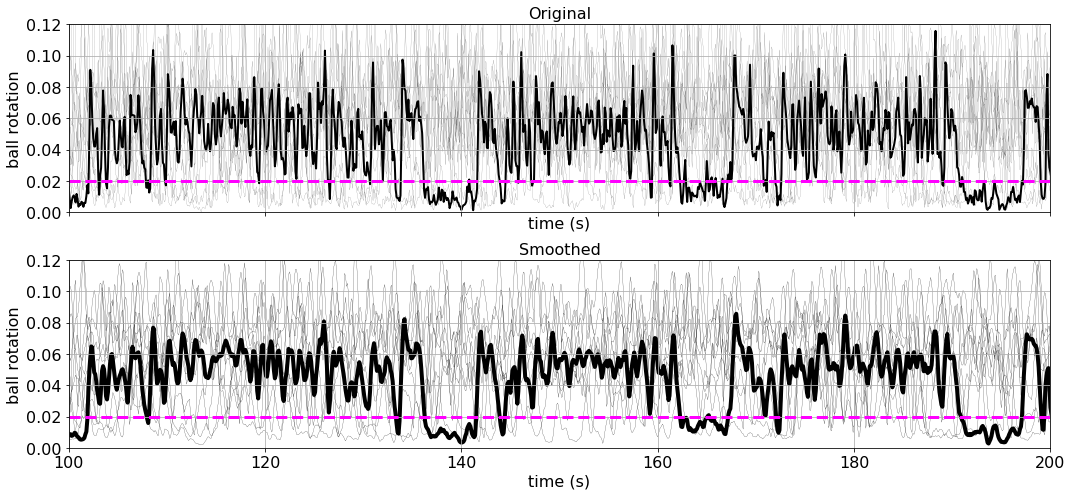

In [7]:
# plot ball rotation for all trials
fig, axs = plt.subplots(2, 1, figsize=(15, 7), tight_layout=True, sharex=True)

for ctr, trial in enumerate(d.trials[:10]):
    
    t = d.d_u[trial]['Time']
    motion = d.d_u[trial]['Motion']
    motion_smooth = d.d_u[trial]['MotionSmooth']
    
    if ctr == 0:
        axs[0].plot(t, motion, color='k', lw=2, zorder=1)
        axs[1].plot(t, motion_smooth, color='k', lw=4, zorder=1)
        
    axs[0].plot(t, motion, color='k', lw=0.1, zorder=0)
    axs[1].plot(t, motion_smooth, color='k', lw=0.2, zorder=0)
    
axs[0].set_title('Original')
axs[1].set_title('Smoothed')

for ax in axs:
    ax.axhline(W_CUTOFF_BALL, color=(1, 0, 1), lw=3, ls='--')
    
    ax.set_xlim(100, 200)
    ax.set_ylim(0, 0.12)
    ax.grid()
    ax.set_xlabel('time (s)')
    ax.set_ylabel('ball rotation')
    
    set_font_size(ax, 16)

In [8]:
def threshold_ball(t, ball_ma):
    
    # preliminary labeling
    state = np.repeat('', len(ball_ma))
    state[ball_ma < W_CUTOFF_BALL] = 'P'  # paused
    state[ball_ma >= W_CUTOFF_BALL] = 'W'  # walking
    
    return state

def pad_state(state):
    
    # pad each segment with 'A' labels indicating transitions/ambiguous state
    state_padded = state.copy()
    
    ## pad paused segs
    segs_p = find_segs(state == 'P')
    
    for start_p, end_p in segs_p:
        
        # pad beginning
        end_p_ = np.min([start_p + int(T_PAD_W/DT), end_p, len(state)])
        state_padded[start_p:end_p_] = 'A'
        
        # pad end
        start_p_ = np.max([end_p - int(T_PAD_W/DT), start_p, 0])
        state_padded[start_p_:end_p] = 'A'
        
    ## pad paused segs
    segs_w = find_segs(state == 'W')
    
    for start_w, end_w in segs_w:
        
        # pad beginning
        end_w_ = np.min([start_w + int(T_PAD_W/DT), end_w, len(state)])
        state_padded[start_w:end_w_] = 'A'
        
        # pad end
        start_w_ = np.max([end_w - int(T_PAD_W/DT), start_w, 0])
        state_padded[start_w_:end_w] = 'A'
        
    return state_padded

In [9]:
frac_w = {trial: None for trial in d.trials}

for trial in d.trials:
    
    # compute states
    state = pad_state(threshold_ball(d.d_u[trial]['Time'], d.d_u[trial]['MotionSmooth']))
    d.d_u[trial]['State'] = state
    d.d_n[trial]['State'] = state
    
    # compute walking fractions
    frac_w[trial] = np.sum(state == 'W') / np.sum(state != 'A')

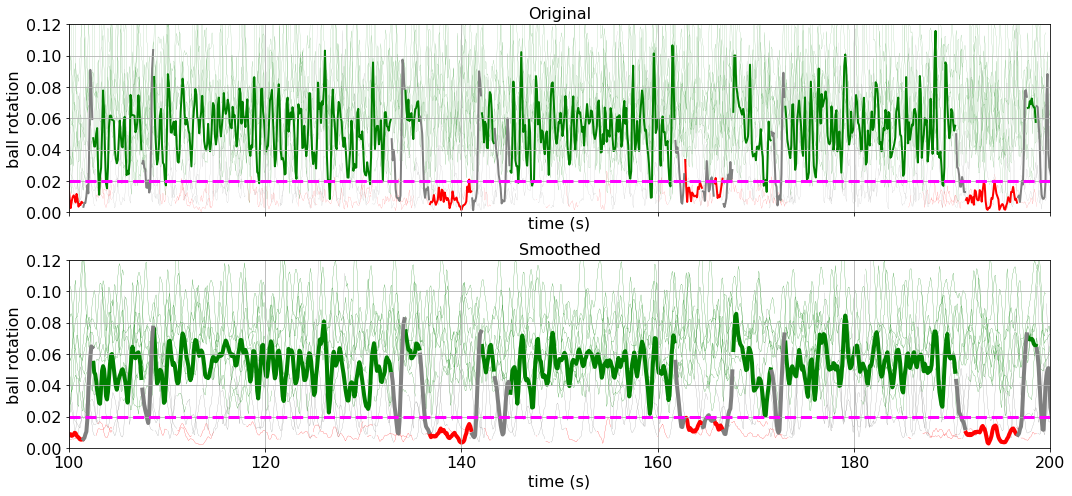

In [10]:
# plot ball rotation colored by state
fig, axs = plt.subplots(2, 1, figsize=(15, 7), tight_layout=True, sharex=True)

for ctr, trial in enumerate(d.trials[:10]):
    
    t = d.d_n[trial]['Time']
    state = d.d_n[trial]['State']
    
    # paused
    ball_p = d.d_u[trial]['Motion'].copy()
    ball_ma_p = d.d_u[trial]['MotionSmooth'].copy()
    
    ball_p[state != 'P'] = np.nan
    ball_ma_p[state != 'P'] = np.nan
    
    # walking
    ball_w = d.d_u[trial]['Motion'].copy()
    ball_ma_w = d.d_u[trial]['MotionSmooth'].copy()
    
    ball_w[state != 'W'] = np.nan
    ball_ma_w[state != 'W'] = np.nan
    
    # ambiguous
    ball_a = d.d_u[trial]['Motion'].copy()
    ball_ma_a = d.d_u[trial]['MotionSmooth'].copy()
    
    ball_a[state != 'A'] = np.nan
    ball_ma_a[state != 'A'] = np.nan
    
    # original
    ## paused
    axs[0].plot(t, ball_p, color='r', lw=0.1, zorder=0)
    ## walking
    axs[0].plot(t, ball_w, color='g', lw=0.1, zorder=0)
    ## ambiguous
    axs[0].plot(t, ball_a, color='gray', lw=0.1, zorder=0)

    # smoothed
    ## paused
    axs[1].plot(t, ball_ma_p, color='r', lw=0.2, zorder=0)
    ## walking
    axs[1].plot(t, ball_ma_w, color='g', lw=0.2, zorder=0)
    ## ambiguous
    axs[1].plot(t, ball_ma_a, color='gray', lw=0.2, zorder=0)
    
    if ctr == 0:
        
        # original
        ## paused
        axs[0].plot(t, ball_p, color='r', lw=2, zorder=1)
        ## walking
        axs[0].plot(t, ball_w, color='g', lw=2, zorder=1)
        ## ambiguous
        axs[0].plot(t, ball_a, color='gray', lw=2, zorder=1)
        
        # smoothed
        ## paused
        axs[1].plot(t, ball_ma_p, color='r', lw=4, zorder=1)
        ## walking
        axs[1].plot(t, ball_ma_w, color='g', lw=4, zorder=1)
        ## ambiguous
        axs[1].plot(t, ball_ma_a, color='gray', lw=4, zorder=1)
    
axs[0].set_title('Original')
axs[1].set_title('Smoothed')

for ax in axs:
    ax.axhline(W_CUTOFF_BALL, color=(1, 0, 1), lw=3, ls='--')
    
    ax.set_xlim(100, 200)
    ax.set_ylim(0, 0.12)
    ax.grid()
    ax.set_xlabel('time (s)')
    ax.set_ylabel('ball rotation')
    
    set_font_size(ax, 16)

# Fit classifier

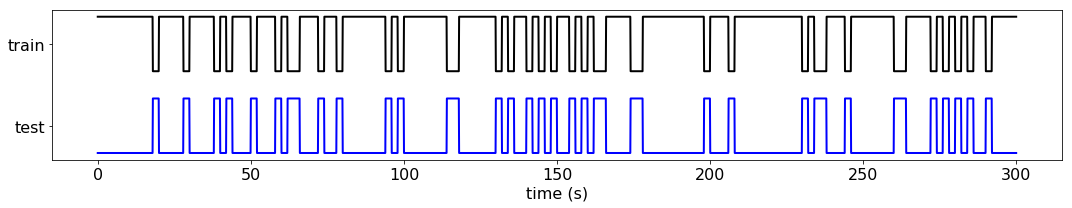

In [11]:
def random_chunk_split(t, frac, dur):
    
    assert t[0] == 0
    
    n_chunks = int(np.ceil(t[-1] / dur))
    starts = np.arange(n_chunks) * dur
    
    n_train = int(round(frac * n_chunks))
    idxs_train = np.random.permutation(n_chunks)[:n_train]
    
    train = np.zeros(t.shape, dtype=bool)
    
    for idx in idxs_train:
        
        start = idx * dur
        end = start + dur
        
        train[(start <= t) & (t < end)] = True
        
    return train, ~train


# test random chunk generator
np.random.seed(0)

t = np.arange(0, 300, 0.1)
train, test = random_chunk_split(t, 0.75, 2)

fig, ax = plt.subplots(1, 1, figsize=(15, 3), tight_layout=True)

ax.plot(t, train + 1.5, color='k', lw=2)
ax.plot(t, test, color='b', lw=2)

ax.set_yticks([0.5, 2])
ax.set_yticklabels(['test', 'train'])

ax.set_xlabel('time (s)')

set_font_size(ax, 16)

In [12]:
def classify_state(preds, trial):
    
    t = d.d_n[trial]['Time']
    
    # make extended predictor matrix
    xs_ = {pred: d.d_n[trial][pred] for pred in preds}
    wdws_filt = {pred: (int(WDW_FILT[0]/DT), int(WDW_FILT[1]/DT)) for pred in preds}
    
    x = make_extended_predictor_matrix(xs_, wdws_filt, preds)
    y = d.d_n[trial]['State']
    
    # construct mask that keeps only non-A states without nan predictors
    mask_valid = (y != 'A') & np.all(~np.isnan(x), axis=1)
    
    # loop over training/test splits
    accs_train = np.nan * np.zeros(N_SPLITS)
    accs_test = np.nan * np.zeros(N_SPLITS)
    
    extras = []
    
    for ctr, split in enumerate(range(N_SPLITS)):
        
        # split data and get valid data
        mask_train, mask_test = random_chunk_split(np.array(t), FRAC, CHUNK_DUR)
        
        x_train = x[mask_train & mask_valid]
        y_train = y[mask_train & mask_valid]
        
        x_test = x[mask_test & mask_valid]
        y_test = y[mask_test & mask_valid]
        
        # fit classifier
        if len(x_train) and len(x_test) and (len(set(y_train)) == 2):
            
            clf = LogisticRegression()
            clf.fit(x_train, y_train)
            
            y_train_hat = clf.predict(x_train)
            y_test_hat = clf.predict(x_test)
            
            acc_train = np.mean(y_train_hat == y_train)
            acc_test = np.mean(y_test_hat == y_test)
            
        else:
            
            acc_train = np.nan
            acc_test = np.nan
            
        accs_train[ctr] = acc_train
        accs_test[ctr] = acc_test
        
    return accs_train, accs_test, extras

In [13]:
# make data storage structures (N_PRED_SETS x N_TRIALS x N_SPLITS)
accs_train = np.nan * np.zeros((len(PRED_SETS), len(d.trials), N_SPLITS))
accs_test = np.nan * np.zeros((len(PRED_SETS), len(d.trials), N_SPLITS))

extras = {preds: {} for preds in PRED_SETS}

# fit classifiers and compute accuracies
np.random.seed(SEED)

for ctr_p, preds in enumerate(PRED_SETS):
    for ctr_tr, trial in enumerate(d.trials):
        
        accs_train_, accs_test_, extra = classify_state(preds, trial)
        
        accs_train[ctr_p, ctr_tr, :] = accs_train_
        accs_test[ctr_p, ctr_tr, :] = accs_test_

In [14]:
# compute mean train/test accuracy for each trial
accs_trial_mean_train = np.nanmean(accs_train, axis=2)
accs_trial_mean_test = np.nanmean(accs_test, axis=2)
            
# compute mean/stds of trial means to get full accuracy means/stds
accs_train_mean = np.nanmean(accs_trial_mean_train, axis=1)
accs_train_std = np.nanstd(accs_trial_mean_train, axis=1)

accs_test_mean = np.nanmean(accs_trial_mean_test, axis=1)
accs_test_std = np.nanstd(accs_trial_mean_test, axis=1)

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


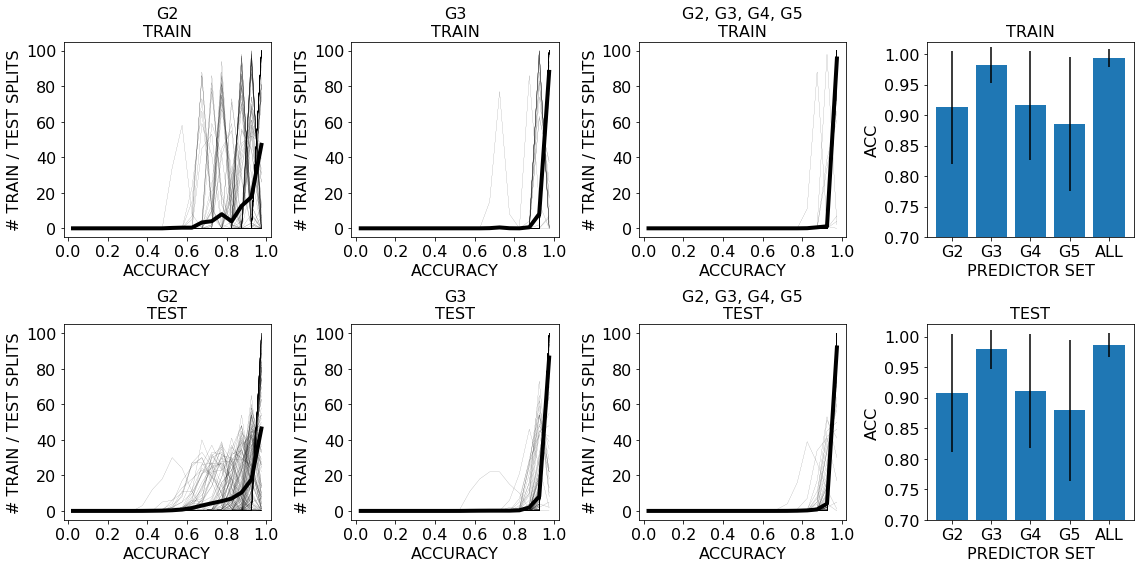

In [15]:
# plot results
fig, axs = plt.subplots(2, 4, figsize=(16, 8), tight_layout=True)
bincs = 0.5 * (BINS[:-1] + BINS[1:])

assert len(PLOT_XMPS) == 3

for ax_col, plot_xmp in enumerate(PLOT_XMPS):
    
    pred_set_idx = PRED_SETS.index(plot_xmp)
    
    cts_train = np.nan * np.zeros((len(d.trials), len(BINS) - 1))
    cts_test = np.nan * np.zeros((len(d.trials), len(BINS) - 1))
    
    for ctr_tr in range(len(d.trials)):
        
        # get trial train and test accs
        accs_train_ = accs_train[pred_set_idx, ctr_tr, :]
        accs_test_ = accs_test[pred_set_idx, ctr_tr, :]
        
        # plot histograms
        if np.any(~np.isnan(accs_train_)):
            cts_train_ = np.histogram(accs_train_[~np.isnan(accs_train_)], bins=BINS)[0]
            cts_train[ctr_tr, :] = cts_train_
            axs[0, ax_col].plot(bincs, cts_train_, color='k', lw=0.1)
        
        if np.any(~np.isnan(accs_test_)):
            cts_test_ = np.histogram(accs_test_[~np.isnan(accs_test_)], bins=BINS)[0]
            cts_test[ctr_tr, :] = cts_test_
            axs[1, ax_col].plot(bincs, cts_test_, color='k', lw=0.1)
        
    axs[0, ax_col].plot(bincs, np.nanmean(cts_train, axis=0), color='k', lw=4)
    axs[1, ax_col].plot(bincs, np.nanmean(cts_test, axis=0), color='k', lw=4)
    
    for ax in axs[:, ax_col]:
        ax.set_xlabel('ACCURACY')
        ax.set_ylabel('# TRAIN / TEST SPLITS')
    
    axs[0, ax_col].set_title('{}\nTRAIN'.format(', '.join(plot_xmp)))
    axs[1, ax_col].set_title('{}\nTEST'.format(', '.join(plot_xmp)))

# make bar plot of trial mean accuracies
x_bar = np.arange(len(PRED_SETS))
x_ticks = x_bar
x_tick_labels = [', '.join(preds) if preds != ('G2', 'G3', 'G4', 'G5',) else 'ALL' for preds in PRED_SETS]

axs[0, -1].bar(x_bar, accs_train_mean, yerr=accs_train_std, align='center')
axs[1, -1].bar(x_bar, accs_test_mean, yerr=accs_test_std, align='center')

axs[0, -1].set_title('TRAIN')
axs[1, -1].set_title('TEST')

for ax in axs[:, -1]:
    ax.set_ylim(0.7, 1.02)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels)
    
    ax.set_xlabel('PREDICTOR SET')
    ax.set_ylabel('ACC')
    
for ax in axs.flatten():
    set_font_size(ax, 16)

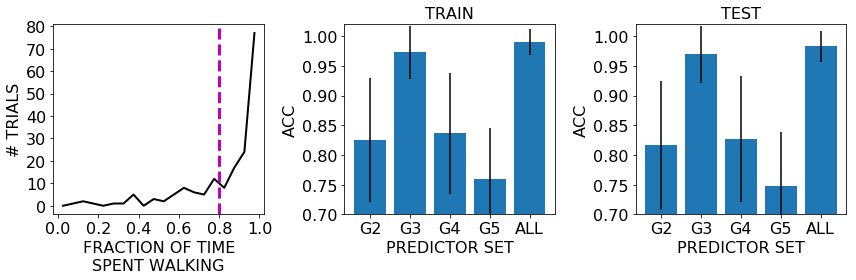

In [16]:
# mask out trials with too high a walking fraction
fracs_w = np.array([frac_w[trial] for trial in d.trials])
mask_frac_w = fracs_w < FRAC_W_CUTOFF

bincs_frac_w = 0.5 * (BINS_FRAC_W[:-1] + BINS_FRAC_W[1:])
cts_frac_w = np.histogram(fracs_w, BINS_FRAC_W)[0]

# compute mean/stds of trial means to get full accuracy means/stds
accs_train_mean_frac_w = np.nanmean(accs_trial_mean_train[:, mask_frac_w], axis=1)
accs_train_std_frac_w = np.nanstd(accs_trial_mean_train[:, mask_frac_w], axis=1)

accs_test_mean_frac_w = np.nanmean(accs_trial_mean_test[:, mask_frac_w], axis=1)
accs_test_std_frac_w = np.nanstd(accs_trial_mean_test[:, mask_frac_w], axis=1)

# plot histogram of walking fraction
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

axs[0].plot(bincs_frac_w, cts_frac_w, color='k', lw=2)

axs[0].axvline(FRAC_W_CUTOFF, color='m', lw=3, ls='--')

axs[0].set_xlabel('FRACTION OF TIME\nSPENT WALKING')
axs[0].set_ylabel('# TRIALS')

# plot acc vs predictor set for "balanced" trials
axs[1].bar(x_bar, accs_train_mean_frac_w, yerr=accs_train_std_frac_w, align='center')
axs[2].bar(x_bar, accs_test_mean_frac_w, yerr=accs_test_std_frac_w, align='center')

axs[1].set_title('TRAIN')
axs[2].set_title('TEST')

for ax in axs[1:]:
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels)
    
    ax.set_ylim(0.7, 1.02)
    
    ax.set_xlabel('PREDICTOR SET')
    ax.set_ylabel('ACC')
    
for ax in axs:
    set_font_size(ax, 16)